<a href="https://colab.research.google.com/github/josephsintum/plant_ml_colab/blob/main/predict_strawberry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# importing script to install ML library(functions)
# bash runs the script to install the library
!wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh
!bash icevision_install.sh cuda11 master

# importing installed library into Python environment
import IPython
IPython.Application.instance().kernel.do_shutdown(True)
from icevision.all import *

--2022-03-08 15:16:52--  https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2691 (2.6K) [text/plain]
Saving to: ‘icevision_install.sh’

icevision_install.s 100%[===================>]   2.63K  --.-KB/s    in 0s      

2022-03-08 15:16:52 (42.1 MB/s) - ‘icevision_install.sh’ saved [2691/2691]

Installing icevision + dependencices for cuda11
- Installing torch and its dependencies
Looking in links: https://download.pytorch.org/whl/torch_stable.html
- Installing mmcv
     |████████████████████████████████| 51.3 MB 204 kB/s 
     |████████████████████████████████| 190 kB 3.6 MB/s 
- Installing mmdet
     |████████████████████████████████| 1.2 MB 5.6 MB/s 
- Installing icevision from mast

INFO     - Downloading default `.ttf` font file - SpaceGrotesk-Medium.ttf from https://raw.githubusercontent.com/airctic/storage/master/SpaceGrotesk-Medium.ttf to /root/.icevision/fonts/SpaceGrotesk-Medium.ttf | icevision.visualize.utils:get_default_font:70
INFO     - Downloading mmdet configs | icevision.models.mmdet.download_configs:download_mmdet_configs:31


  0%|          | 0/1837152 [00:00<?, ?B/s]

In [1]:
# cloning dataset from Github
!git clone https://github.com/josephsintum/PlantDoc-Object-Detection-Dataset.git

Cloning into 'PlantDoc-Object-Detection-Dataset'...
remote: Enumerating objects: 5217, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 5217 (delta 7), reused 18 (delta 6), pack-reused 5190
Receiving objects: 100% (5217/5217), 1.00 GiB | 30.58 MiB/s, done.
Resolving deltas: 100% (2335/2335), done.
Checking out files: 100% (5209/5209), done.


In [2]:
# navigate to the data directory
!pwd  # output: '/content'
%cd PlantDoc-Object-Detection-Dataset/
!ls

/content
/content/PlantDoc-Object-Detection-Dataset
images	     TEST	      train_labels.csv
LICENSE.txt  test_labels.csv  train_labels_strawberry.csv
models	     TRAIN	      train_labels_tomatoes.csv


In [3]:
from icevision.all import *

# reading the path to data into data_dir variable
data_dir = Path('.')
print(data_dir)

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /root/.icevision/mmdetection_configs/mmdetection_configs-2.20.1/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:18


.


In [4]:
# importing pandas library(Data analysis library)
import pandas as pd

annot = pd.read_csv('train_labels_strawberry.csv') # reading the data csv file
annot.rename(columns={'class': 'label'}, inplace=True) # renaming the class column to label
annot.sample(3)

,filename,width,height,label,xmin,ymin,xmax,ymax
11,bfeba4aaa5a042494590b027686e1d16.jpg,600,430,Strawberry leaf,347,15,571,250
28,Strawberry+leaves.jpg,1080,810,Strawberry leaf,151,141,543,554
42,depositphotos_3121648-Strawberry-leaf.jpg,1024,909,Strawberry leaf,500,447,933,822


In [5]:
# checking the number of records
annot.filename.nunique()

88

In [6]:
_CLASSES = annot['label'].unique().tolist() # gets all the unique labels 
len(_CLASSES) # prints number of unique labels

class_map = ClassMap(_CLASSES) # create a map data structure(using the label as id)

In [7]:
template_record = ObjectDetectionRecord() # organizes information for path, bounding box and labels

class PlantDocParser(Parser): # parser gives the directions for arranging the data
    def __init__(self, template_record, data_dir):
        super().__init__(template_record=template_record)
        self.data_dir = data_dir
        self.df = annot
        self.class_map = class_map

    # allows data to be iterable
    def __iter__(self) -> Any:
        for o in self.df.itertuples():
            yield o

    # returns length of data
    def __len__(self) -> int:
        return len(self.df)

    # returns id(filename) of item
    def record_id(self, o) -> Hashable:
        return o.filename

    # training images and labels are gathered into a record
    # image size is collected
    def parse_fields(self, o, record, is_new):
        if is_new:
            filepath = self.data_dir / 'TRAIN' / o.filename
            record.set_filepath(filepath)
            if filepath.exists():
                image_size = get_img_size(filepath)
                record.set_img_size(image_size)  #
            record.detection.set_class_map(self.class_map)
        record.detection.add_bboxes(
            [BBox.from_xyxy(o.xmin, o.ymin, o.xmax, o.ymax)])
        record.detection.add_labels([o.label])

  0%|          | 0/462 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/88 [00:00<?, ?it/s]

BaseRecord

common: 
	- Record ID: depositphotos_6570375-stock-photo-strawberry-leaf.jpg
	- Image size ImgSize(width=1023, height=861)
	- Filepath: TRAIN/depositphotos_6570375-stock-photo-strawberry-leaf.jpg
	- Img: None
detection: 
	- BBoxes: [<BBox (xmin:411, ymin:48, xmax:822, ymax:422)>, <BBox (xmin:465, ymin:436, xmax:870, ymax:817)>, <BBox (xmin:105, ymin:351, xmax:451, ymax:765)>]
	- Class Map: <ClassMap: {'background': 0, 'Strawberry leaf': 1}>
	- Labels: [1, 1, 1]

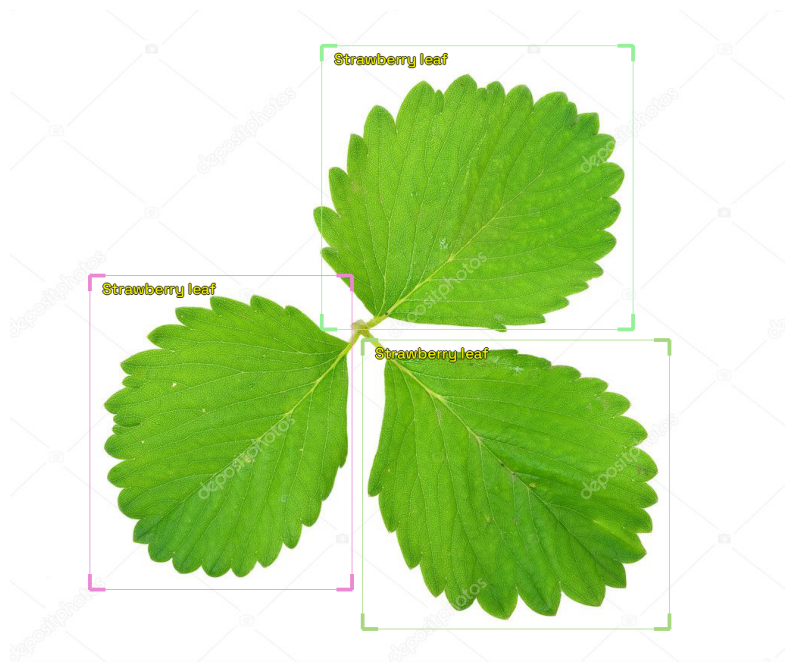

In [8]:
# create instance of class with the template structure and data directory
parser = PlantDocParser(template_record, data_dir)
train_records, valid_records = parser.parse()
show_record(train_records[0], class_map=class_map, 
            figsize = (10,10),font_size=20, label_color = '#ffff00')
train_records[0]

In [9]:
#
presize = 512
image_size = 384

valid_tfms = tfms.A.Adapter(
    [*tfms.A.resize_and_pad(size=image_size), tfms.A.Normalize()])
valid_ds = Dataset(valid_records, valid_tfms)

In [10]:
path = '/content/PlantDoc-Object-Detection-Dataset/models/plantdoc-yolov5_strawberry.pth'
model_type = models.ultralytics.yolov5 # ML model
backbone = model_type.backbones.small 
model = model_type.model(backbone=backbone(pretrained=True),
                                 num_classes=len(parser.class_map), img_size=image_size)
state_dict = torch.load(path, map_location=torch.device('cpu')) # loading the model, images
model.load_state_dict(state_dict) 

  0%|          | 0.00/14.1M [00:00<?, ?B/s]

03/08/2022 15:21:51 - INFO - yolov5.models.yolo -   Overriding model.yaml nc=80 with nc=1
03/08/2022 15:21:51 - INFO - yolov5.models.yolo -   
                 from  n    params  module                                  arguments                     
03/08/2022 15:21:51 - INFO - yolov5.models.yolo -     0                -1  1      3520  yolov5.models.common.Conv               [3, 32, 6, 2, 2]              
03/08/2022 15:21:51 - INFO - yolov5.models.yolo -     1                -1  1     18560  yolov5.models.common.Conv               [32, 64, 3, 2]                
03/08/2022 15:21:51 - INFO - yolov5.models.yolo -     2                -1  1     18816  yolov5.models.common.C3                 [64, 64, 1]                   
03/08/2022 15:21:51 - INFO - yolov5.models.yolo -     3                -1  1     73984  yolov5.models.common.Conv               [64, 128, 3, 2]               
03/08/2022 15:21:51 - INFO - yolov5.models.yolo -     4                -1  2    115712  yolov5.models.common.C3   

03/08/2022 15:21:51 - INFO - yolov5.models.yolo -     9                -1  1    656896  yolov5.models.common.SPPF               [512, 512, 5]                 
03/08/2022 15:21:51 - INFO - yolov5.models.yolo -    10                -1  1    131584  yolov5.models.common.Conv               [512, 256, 1, 1]              
03/08/2022 15:21:51 - INFO - yolov5.models.yolo -    11                -1  1         0  torch.nn.modules.upsampling.Upsample    [None, 2, 'nearest']          
03/08/2022 15:21:51 - INFO - yolov5.models.yolo -    12           [-1, 6]  1         0  yolov5.models.common.Concat             [1]                           
03/08/2022 15:21:51 - INFO - yolov5.models.yolo -    13                -1  1    361984  yolov5.models.common.C3                 [512, 256, 1, False]          
03/08/2022 15:21:51 - INFO - yolov5.models.yolo -    14                -1  1     33024  yolov5.models.common.Conv               [256, 128, 1, 1]              
03/08/2022 15:21:51 - INFO - yolov5.models.yol

<All keys matched successfully>

In [11]:
# Pick your images folder
path_to_image_folder = "/content/PlantDoc-Object-Detection-Dataset/images"
img_files = get_image_files(path_to_image_folder)

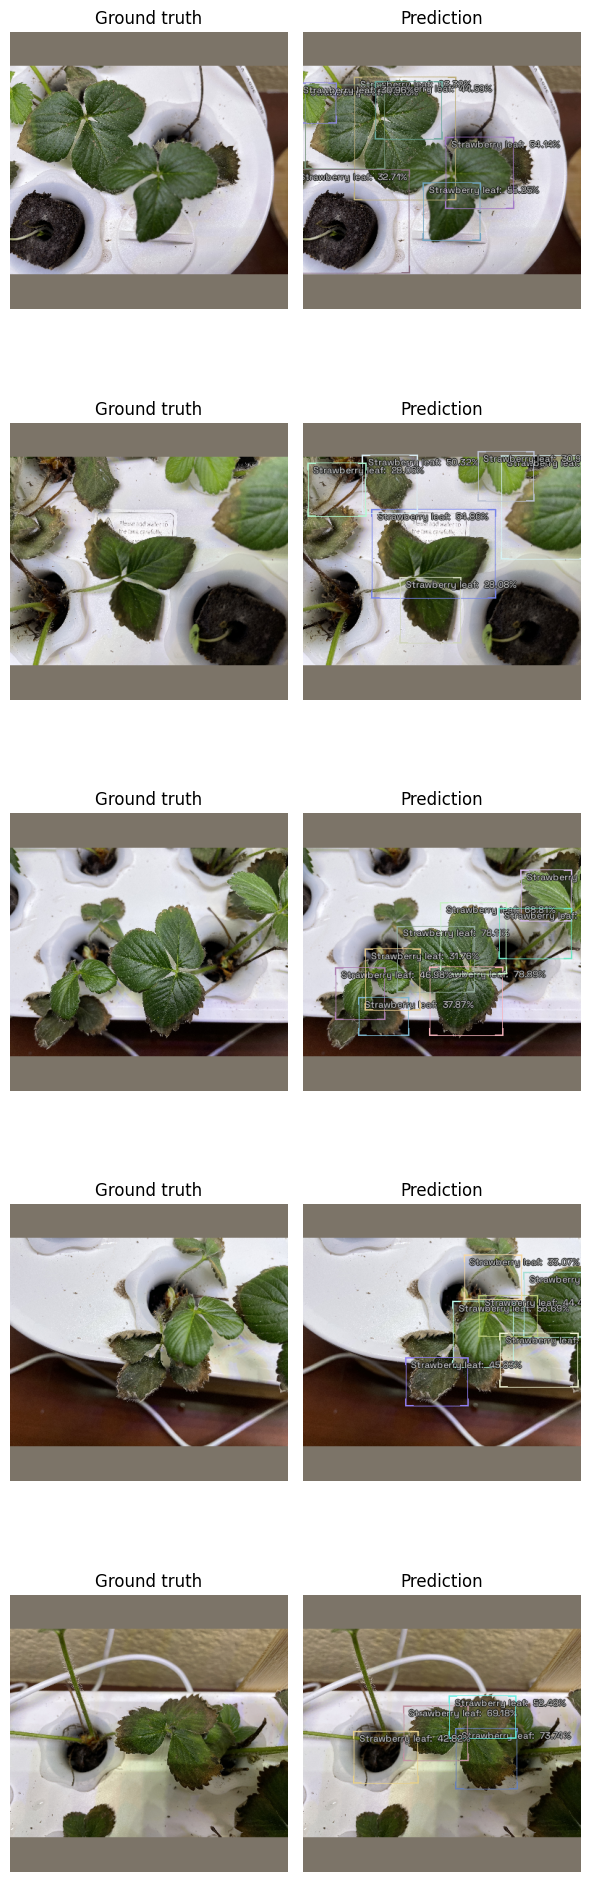

In [14]:
img = PIL.Image.open(img_files[2]) # extract and load images
imgs_array = [PIL.Image.open(Path(fname)) for fname in img_files]

infer_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=384), tfms.A.Normalize()])
infer = Dataset.from_images(imgs_array, infer_tfms, class_map=class_map )
preds = model_type.predict(model, infer, keep_images=True)
show_preds(preds=preds)